# Détection de spams

4601 observations, 57 variables (numériques)

Attribute Information:

The last column of 'spambase.data' denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. Most of the attributes indicate whether a particular word or character was frequently occuring in the e-mail. The run-length attributes (55-57) measure the length of sequences of consecutive capital letters. For the statistical measures of each attribute, see the end of this file. Here are the definitions of the attributes:

48 continuous real [0,100] attributes of type word_freq_WORD = percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail. A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string.

6 continuous real [0,100] attributes of type char_freq_CHAR] = percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail

1 continuous real [1,...] attribute of type capital_run_length_average = average length of uninterrupted sequences of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_longest = length of longest uninterrupted sequence of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_total = sum of length of uninterrupted sequences of capital letters = total number of capital letters in the e-mail

1 nominal {0,1} class attribute of type spam = denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail.

source : https://archive.ics.uci.edu/ml/datasets/Spambase

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn import neighbors
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, roc_curve
from sklearn import linear_model

## Importation des données

In [11]:
varnames = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names",
                  sep=":",
                  skiprows=33,
                  names = ["name","type"],
                  header=None)
varnames = list(  varnames["name"])+["class"] 

data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data",
                  sep=",",
                  names = varnames,
                  header=None)

data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [12]:
data_np = data.to_numpy()


# Avec sélection de 3 classes
X = data_np[:,:-1]
print("Taille de X : ",X.shape)
Y = data_np[:,-1]
print("Longueur de Y : ", Y.shape)

Taille de X :  (4601, 57)
Longueur de Y :  (4601,)


## Statistiques descriptives

Text(0.5, 1.0, 'Répartition du type de messages')

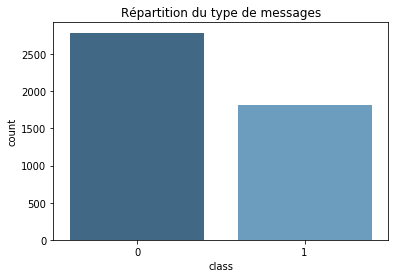

In [13]:
sns.countplot(x="class",data=data,palette="Blues_d")
plt.title("Répartition du type de messages")

Text(0, 0.5, 'PC2 (6.0%)')

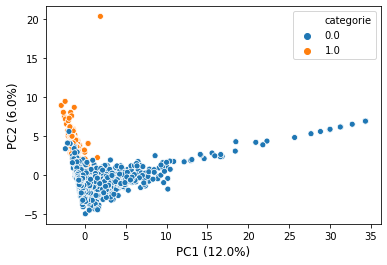

In [14]:
from sklearn.decomposition import PCA


scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X_sc)

PC = pca.transform(X_sc)

d = {'PC1': PC[:,0], 'PC2': PC[:,1], 'categorie':Y}
df = pd.DataFrame(data=d)

sns.scatterplot(x="PC1",y="PC2",hue="categorie",data = df)
plt.xlabel("PC1 ("+str(round(pca.explained_variance_ratio_[0]*100))+"%)" , size = 12 ) 
plt.ylabel( "PC2 ("+str(round(pca.explained_variance_ratio_[1]*100))+"%)"  , size = 12 ) 

Un premier exemple de construction d'un arbre de classification. On commence comme d'habitude à générer un ensemble d'apprentissage et un ensemble de test. L'argument random_state permet de fixer la graine du générateur pseudo-aléatoire. 


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

Un exemple d'arbre de décision

In [16]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

On peut alors représenter l'arbre obtenu. Dans chaque noeud, on retrouve la règle de coupure, la vleur de l'indice de Gini, le nombre d'observations et, dans "value" le nombre d'individus de la classe ham et celui de la classe spam. 
Plus la case est orange et plus la proportion de ham est forte et inversement plus la feuille est bleue et plus la proportion de spam est forte. 
Rq : ces proportions sont calculées sur l'ensemble d'apprentissage. 

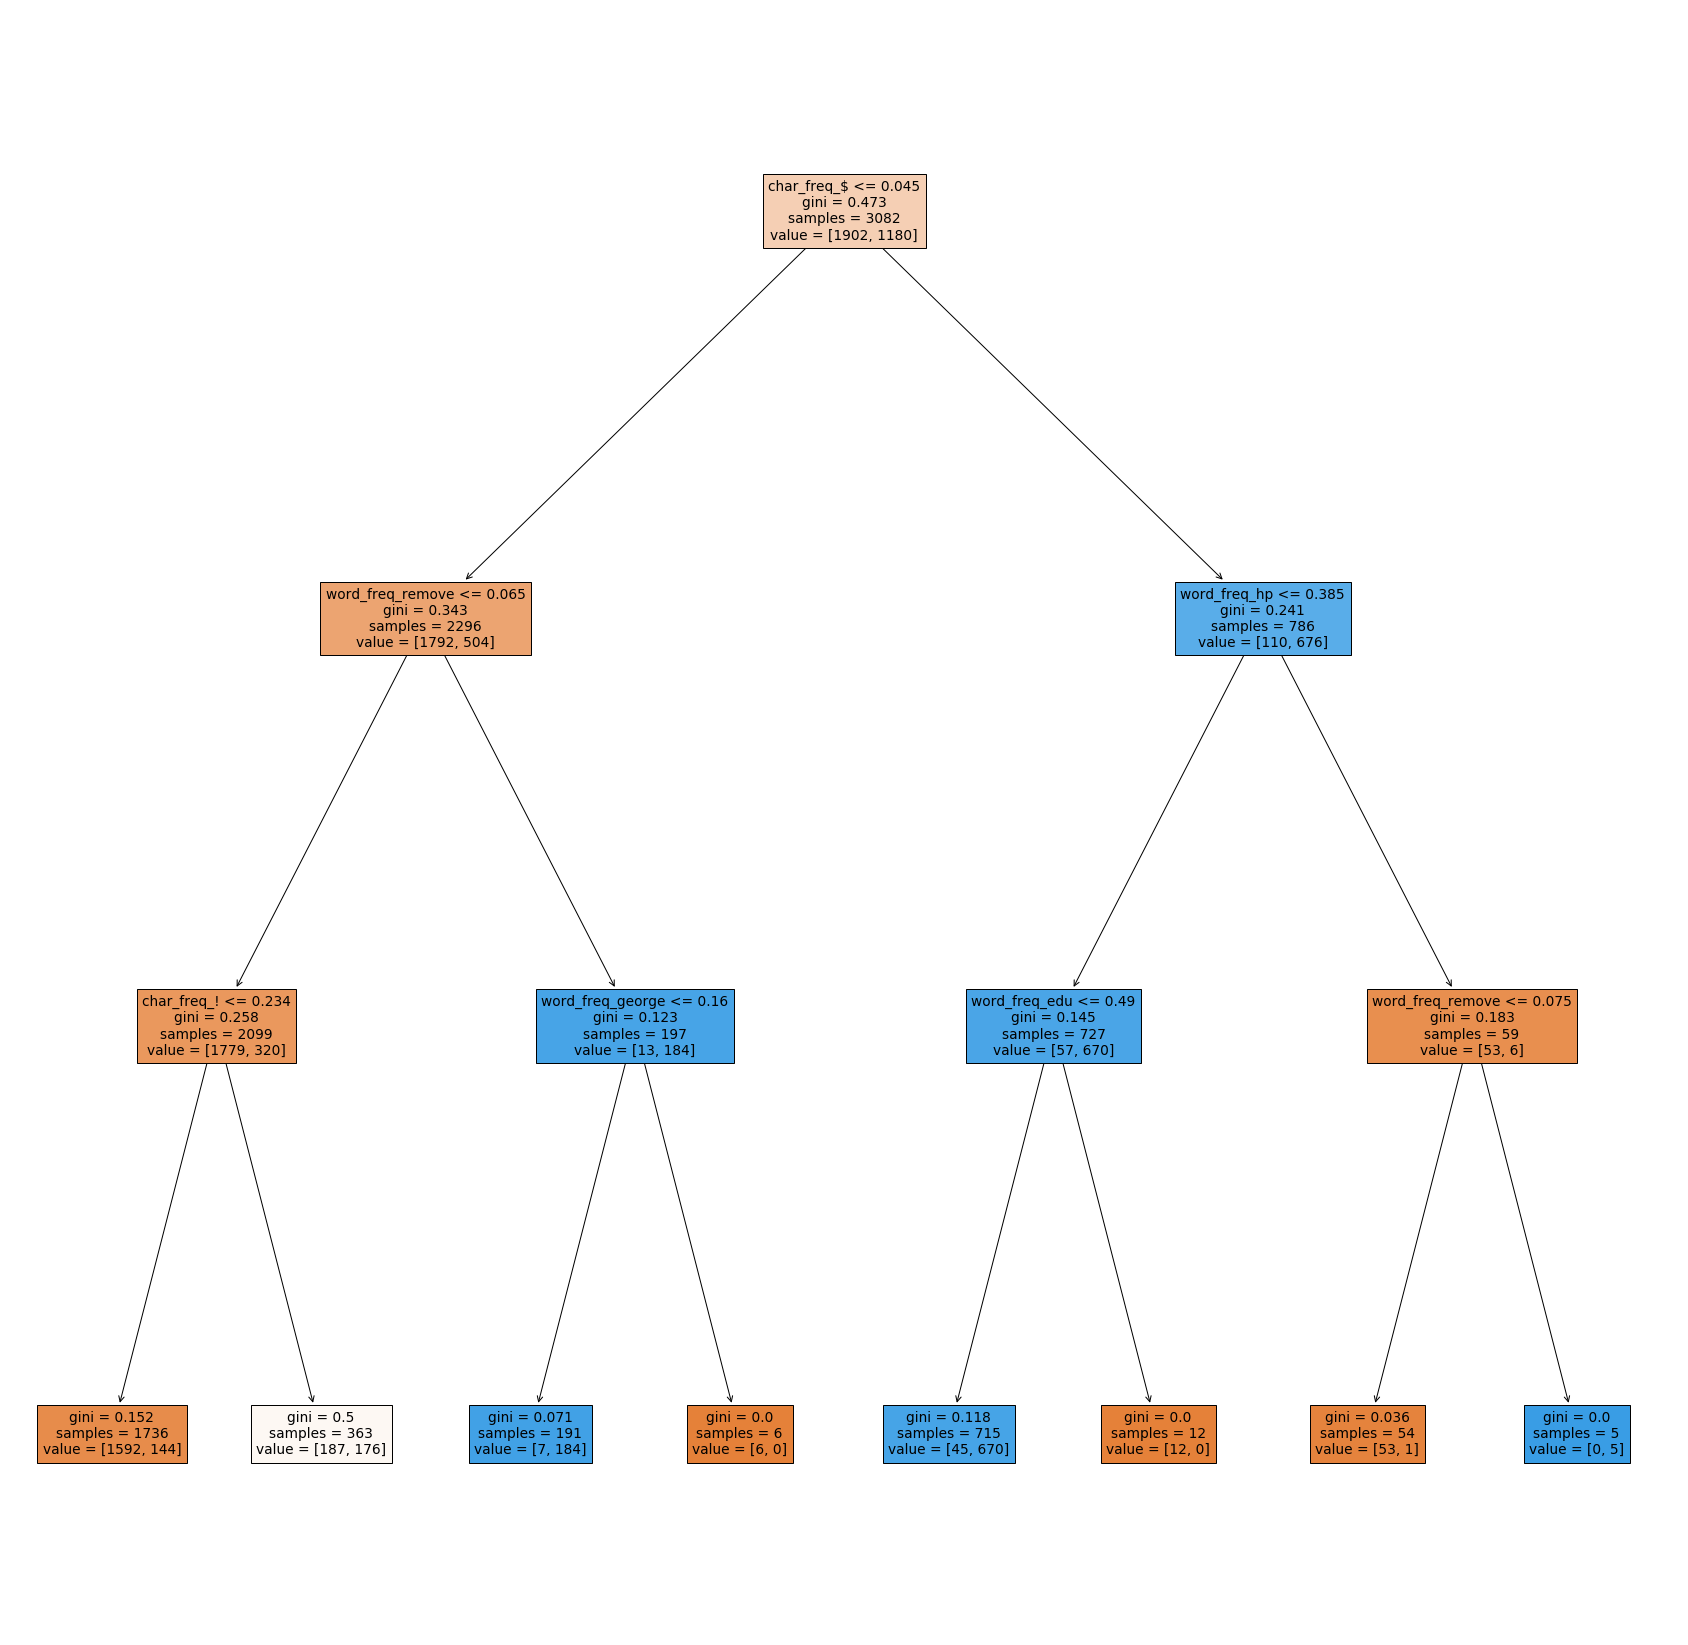

In [17]:
plt.figure(figsize=(30,30))
plot_tree(clf,filled=True, feature_names=varnames) 
plt.show()

## Crières performance

    Accuracy = proportion d'individus bien classés (toutes classes confondues)

    Precision : proportion d'individus bien classés dans a classe "positive" . Dans le cas des spam la classe positive devrait être la classe des spams. 

    Ici, une liste : https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/


On cherche maintenant à optimiser l'arbre de décision en faisant varier plusieurs hyper-paramètres. 

In [18]:
# Generation of the B training/validation sets
B = 30
cv = ShuffleSplit(n_splits=B, 
                  test_size=0.3, 
                  random_state=0)
from sklearn.model_selection import KFold
B = 5
cv = KFold(n_splits=B, random_state=None, shuffle=True)

In [19]:
param_grid = {'max_depth':[5,10,15,20], 
             'min_samples_leaf':[5,10,15,20],
             'splitter' : ['best', 'random']}
clf = DecisionTreeClassifier()
search = GridSearchCV(clf, 
                      param_grid, 
                      scoring="accuracy",
                      cv=cv,
                      n_jobs=-1)
search.fit(X_train,y_train)
print('Meilleur modèle')
print(search.best_estimator_)

Meilleur modèle
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


Mesures de performances pour le meilleur arbre

In [ ]:
scoring=("accuracy","precision","recall","f1","roc_auc")

tree = search.best_estimator_
cv_scores = cross_validate(tree, X_train, y_train, cv=cv,scoring=scoring)

print("Performances de l'arbre de décision")
print("Accuracy  : ", np.round(np.mean(cv_scores["test_accuracy"]),2), "(",np.round(np.std(cv_scores["test_accuracy"]),2),")")
print("Precision : ", np.round(np.mean(cv_scores["test_precision"]),2), "(",np.round(np.std(cv_scores["test_precision"]),2),")")
print("Recall    : ", np.round(np.mean(cv_scores["test_recall"]),2), "(",np.round(np.std(cv_scores["test_recall"]),2),")")
print("F1-score  : ", np.round(np.mean(cv_scores["test_f1"]),2), "(",np.round(np.std(cv_scores["test_f1"]),2),")")
print("AUC       : ", np.round(np.mean(cv_scores["test_roc_auc"]),2), "(",np.round(np.std(cv_scores["test_roc_auc"]),2),")")

Performances de l'arbre de décision
Accuracy  :  0.9 ( 0.01 )
Precision :  0.89 ( 0.02 )
Recall    :  0.85 ( 0.02 )
F1-score  :  0.87 ( 0.02 )
AUC       :  0.93 ( 0.01 )


Confusion matrix  : 
[[842  44]
 [101 532]]
 
Confusion matrix (proportions) : 
[[0.95 0.05]
 [0.16 0.84]]
 


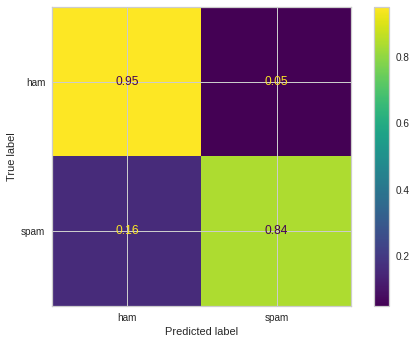

<Figure size 432x432 with 0 Axes>

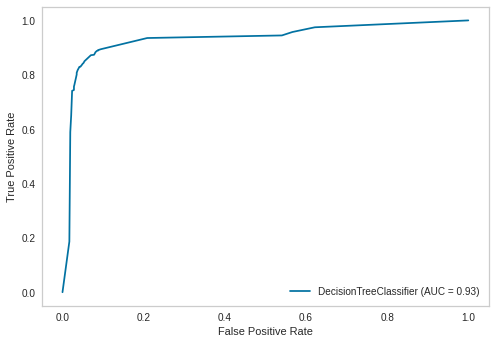

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_tree = tree.predict(X_test)
print("Confusion matrix  : ")
print(confusion_matrix(y_test,y_pred_tree))
print(' ')
print("Confusion matrix (proportions) : ")
cm = confusion_matrix(y_test,y_pred_tree,normalize='true')
print(np.round(cm,2))
print(' ')

ConfusionMatrixDisplay(cm, display_labels=["ham","spam"]).plot()
                                       

plt.figure(figsize=(6,6))
plot_roc_curve(tree,X_test,y_test)
plt.grid()

tree_fpr, tree_tpr, thresholds = roc_curve(y_test, y_pred_tree)

In [ ]:
from sklearn.inspection import permutation_importance
r = permutation_importance(tree, X_train_sc, y_train,
                            n_repeats=30,
                            random_state=0)

print("Importance des variables :" )
print(data.columns[r.importances_mean.argsort()[::-1]])


Importance des variables :
Index(['word_freq_remove', 'char_freq_!', 'word_freq_free',
       'word_freq_internet', 'word_freq_your', 'word_freq_george',
       'word_freq_order', 'word_freq_edu', 'word_freq_business',
       'word_freq_our', 'word_freq_hp', 'capital_run_length_longest',
       'word_freq_all', 'word_freq_hpl', 'word_freq_re', 'word_freq_email',
       'word_freq_will', 'word_freq_85', 'word_freq_pm', 'word_freq_font',
       'word_freq_000', 'word_freq_credit', 'word_freq_money',
       'capital_run_length_total', 'word_freq_addresses', 'word_freq_report',
       'word_freq_receive', 'word_freq_mail', 'word_freq_over', 'word_freq_3d',
       'word_freq_address', 'word_freq_people', 'word_freq_lab',
       'word_freq_650', 'word_freq_cs', 'char_freq_#', 'char_freq_[',
       'char_freq_(', 'word_freq_conference', 'word_freq_table',
       'word_freq_project', 'word_freq_original', 'word_freq_labs',
       'word_freq_meeting', 'word_freq_direct', 'word_freq_parts',
    

## Algorithme des plus proches voisins


In [ ]:
knn = neighbors.KNeighborsClassifier(weights="distance",metric="manhattan")
#param_grid = [{'n_neighbors': [1,5,10,20], 
#               'weights': ['uniform','distance'],
#               'metric': ['euclidean','manhattan']}]
param_grid = [{'n_neighbors': [1,5,10,20]}]
# Optimization of the hyperparameters
search = GridSearchCV(knn, 
                      param_grid, 
                      scoring="accuracy",
                      cv=cv,
                      n_jobs=-1)
search.fit(X_train_sc,y_train)
print('Meilleur modèle')
print(search.best_estimator_)

Meilleur modèle
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')


In [ ]:
knn_best = search.best_estimator_
cv_scores = cross_validate(knn_best, X_train_sc, y_train, cv=cv,scoring=scoring)

print("Performances de l'estimateur des plus proches voisins")
print("Accuracy  : ", np.round(np.mean(cv_scores["test_accuracy"]),2), "(",np.round(np.std(cv_scores["test_accuracy"]),2),")")
print("Precision : ", np.round(np.mean(cv_scores["test_precision"]),2), "(",np.round(np.std(cv_scores["test_precision"]),2),")")
print("Recall    : ", np.round(np.mean(cv_scores["test_recall"]),2), "(",np.round(np.std(cv_scores["test_recall"]),2),")")
print("F1-score  : ", np.round(np.mean(cv_scores["test_f1"]),2), "(",np.round(np.std(cv_scores["test_f1"]),2),")")
print("AUC       : ", np.round(np.mean(cv_scores["test_roc_auc"]),2), "(",np.round(np.std(cv_scores["test_roc_auc"]),2),")")

Performances de l'estimateur des plus proches voisins
Accuracy  :  0.91 ( 0.01 )
Precision :  0.94 ( 0.01 )
Recall    :  0.82 ( 0.02 )
F1-score  :  0.88 ( 0.01 )
AUC       :  0.97 ( 0.01 )


Confusion matrix (proportions) : 
 


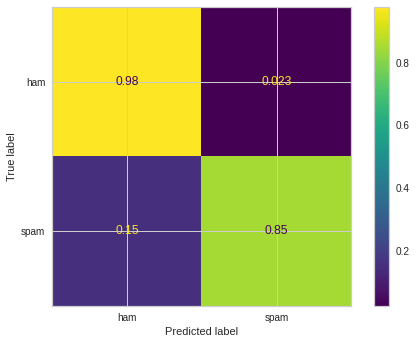

<Figure size 432x432 with 0 Axes>

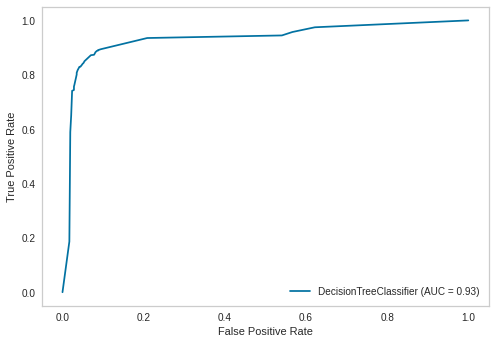

In [ ]:
y_pred_knn = knn_best.predict(X_test_sc)
print("Confusion matrix (proportions) : ")
cm = confusion_matrix(y_test,y_pred_knn,normalize='true')
#print(np.round(cm,2))
print(' ')

ConfusionMatrixDisplay(cm, display_labels=["ham","spam"]).plot()
                                       

plt.figure(figsize=(6,6))
plot_roc_curve(tree,X_test,y_test)
plt.grid()

tree_fpr, tree_tpr, thresholds = roc_curve(y_test, y_pred_tree)

knn_fpr, knn_tpr, thresholds = roc_curve(y_test, y_pred_knn)

On observe la mathoe des ppv permet d'améliorer la détection des ham mais pas des spams... 

Comparaison des 2 modèles


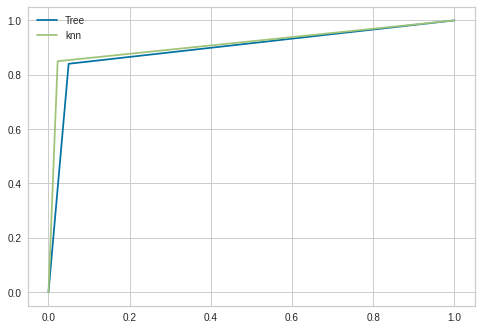

In [ ]:

plt.plot(tree_fpr,tree_tpr,label="Tree")
plt.plot(knn_fpr,knn_tpr,label = "knn")
plt.legend()

# Situation de grande dimension

Dans ce jeu de données, on a 57 variables. Pour se mettre en situation de grande dimension avec p (nombre de variables) de l'ordre de n (nombre d'observations), on peut par exemple générer un ensemble d'apprentissage de 50 observations. [solution 1]

L'ensemble de test sert uniquement à la validation des algorithmes. On peut donc garder le reste des observations dans l'ensemble de test. 

On pourrait aussi tirer les observation de l'ensemble d'apprentissage dans l'ensemble d'apprentissage de la première partie pour conserver le mêême ensemble de test pour toutes les questions et ainsi obtenir des résultats comparables. [solution 2]

Avec les solutions 1 et 2 on réduit beaucoup la taille de l'ensemble d'apprentissage. Les performances des classifieursvont se dégrader. Mais il sera difficile de savori si la dégradation vient de la réduction du nombre d'exemples disponibles pour entrainer les modèles ou de la grande dimension. 

Un 3eme solution consiste alors à ajouter des variables générées aléatoirement à la base de données. [solution 3]

In [ ]:
Xt_old = X_train_sc
yt_old = y_train

In [ ]:
# Solution 1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=X.shape[0]-50, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train.shape

(50, 57)

In [ ]:
# Solution 2

X_train_sc, X_test1, y_train, y_test1 = train_test_split(Xt_old, yt_old, test_size=X_train.shape[0]-50, random_state=42)

X_train_sc.shape

(50, 57)

In [ ]:
# Solution 3
from numpy import random
Z =  random.normal(loc=0.0, scale=1.0, size=(X.shape[0],X.shape[0]))
X_new  = np.concatenate((X,Z),axis=1)
X_new.shape

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new, Y, test_size=.33, random_state=42)


scaler = StandardScaler()
X_train_sc2 = scaler.fit_transform(X_train2)
X_test_sc2 = scaler.transform(X_test2)

## Arbre de décision

ajusté sur la table de la solution 3 (les temps de calculs sont longs). 

Il faudrait peut-être réduire la grille de paramètres. Je mets en commentaire la recherche et j'ajuste un arbre avec les paramètres sélectionns à la question précédente. 

In [ ]:
param_grid = {'max_depth':[5,10,15,20], 
             'min_samples_leaf':[5,10,15,20],
             'splitter' : ['best', 'random']}
clf = DecisionTreeClassifier()
#search = GridSearchCV(clf, 
#                      param_grid, 
#                      scoring="accuracy",
#                      cv=cv,
#                      n_jobs=-1)

tree = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


tree.fit(X_train_sc2,y_train2)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
scoring=("accuracy","precision","recall","f1","roc_auc")
# Generation of the B training/validation sets
B = 3 # on fait seulement 3 tirages pour gagenr du temps
cv = ShuffleSplit(n_splits=B, 
                  test_size=0.3, 
                  random_state=0)

cv_scores = cross_validate(tree, X_train_sc2, y_train2, cv=cv,scoring=scoring)

print("Performances de l'arbre de décision")
print("Accuracy  : ", np.round(np.mean(cv_scores["test_accuracy"]),2), "(",np.round(np.std(cv_scores["test_accuracy"]),2),")")
print("Precision : ", np.round(np.mean(cv_scores["test_precision"]),2), "(",np.round(np.std(cv_scores["test_precision"]),2),")")
print("Recall    : ", np.round(np.mean(cv_scores["test_recall"]),2), "(",np.round(np.std(cv_scores["test_recall"]),2),")")
print("F1-score  : ", np.round(np.mean(cv_scores["test_f1"]),2), "(",np.round(np.std(cv_scores["test_f1"]),2),")")
print("AUC       : ", np.round(np.mean(cv_scores["test_roc_auc"]),2), "(",np.round(np.std(cv_scores["test_roc_auc"]),2),")")

Performances de l'arbre de décision
Accuracy  :  0.87 ( 0.01 )
Precision :  0.86 ( 0.03 )
Recall    :  0.79 ( 0.01 )
F1-score  :  0.82 ( 0.02 )
AUC       :  0.86 ( 0.02 )


Confusion matrix (proportions) : 
 


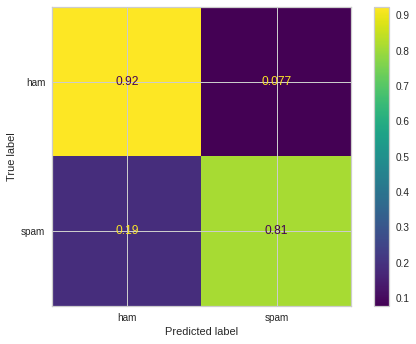

In [ ]:
y_pred_tree = tree.predict(X_test_sc2)
print("Confusion matrix (proportions) : ")
cm = confusion_matrix(y_test2,y_pred_tree,normalize='true')
#print(np.round(cm,2))
print(' ')

ConfusionMatrixDisplay(cm, display_labels=["ham","spam"]).plot()

On observe une petite dégradation des résultats. On perd 3% de bonnes classifications dans les 2 classes. 

# Situation de classes deséquilibrées
On génére un ensemble comportant très peu de spam.

In [ ]:
i_spam = np.where(Y==1)[0]
print(len(i_spam))
i_ham = np.where(Y==0)[0]
i_spam_keep = np.random.choice(i_spam,size = int(np.round(len(i_spam)/100)))

i_ham_keep = np.random.choice(i_ham,size = 99*len(i_spam_keep))

X_deseq = np.concatenate((X[i_spam_keep,:],X[i_ham_keep,:]),axis=0)
X_deseq.shape


Y_deseq = np.concatenate((Y[i_spam_keep],Y[i_ham_keep]),axis=0)

print("Proportion de spam : ", np.mean(Y_deseq))


scaler = StandardScaler()
X_deseq_sc = scaler.fit_transform(X_deseq)


1813
Proportion de spam :  0.01


In [ ]:
param_grid = {'max_depth':[5,10,15,20], 
             'min_samples_leaf':[5,10,15,20],
             'splitter' : ['best', 'random']}
clf = DecisionTreeClassifier()
search = GridSearchCV(clf, 
                      param_grid, 
                      scoring="accuracy",
                      cv=cv,
                      n_jobs=-1)
search.fit(X_deseq,Y_deseq)
print('Meilleur modèle')
print(search.best_estimator_)

Meilleur modèle
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')


In [ ]:
tree_best = search.best_estimator_
cv_scores = cross_validate(tree_best, X_deseq, Y_deseq, cv=cv,scoring=scoring)

print("Performances de l'estimateur des plus proches voisins")
print("Accuracy  : ", np.round(np.mean(cv_scores["test_accuracy"]),2), "(",np.round(np.std(cv_scores["test_accuracy"]),2),")")
print("Precision : ", np.round(np.mean(cv_scores["test_precision"]),2), "(",np.round(np.std(cv_scores["test_precision"]),2),")")
print("Recall    : ", np.round(np.mean(cv_scores["test_recall"]),2), "(",np.round(np.std(cv_scores["test_recall"]),2),")")
print("F1-score  : ", np.round(np.mean(cv_scores["test_f1"]),2), "(",np.round(np.std(cv_scores["test_f1"]),2),")")
print("AUC       : ", np.round(np.mean(cv_scores["test_roc_auc"]),2), "(",np.round(np.std(cv_scores["test_roc_auc"]),2),")")

Performances de l'estimateur des plus proches voisins
Accuracy  :  0.98 ( 0.0 )
Precision :  0.08 ( 0.12 )
Recall    :  0.05 ( 0.07 )
F1-score  :  0.06 ( 0.09 )
AUC       :  0.74 ( 0.02 )


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


L'accuracy est très bonne : on classe bien tous les ham. En revanche on observe que les autres critères (principalement basés sur les spams bien classés) sont mauvais.

La solution consiste à ré-équilibrer artificiellement les classes dans l'ensemble d'apprentissage. On peut le faire par sous échantillonnage ou sur-échantilonnage. Les méthodes les plus utilisées sont la méthode SMOTE et la méthode

Pour comparer, on peut générer un jeu de données de même taille avec des proportions de classe mieux équilibrées.


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter

smote = SMOTE(sampling_strategy=0.3) # sampling_strateg proportion de 1 dans le nouvel échantillon
Xsmote, Ysmote = smote.fit_resample(X_deseq, Y_deseq)

print(Counter(Ysmote))


cv_scores = cross_validate(tree_best, Xsmote, Ysmote, cv=cv,scoring=scoring)

print("Performances de l'estimateur des plus proches voisins")
print("Accuracy  : ", np.round(np.mean(cv_scores["test_accuracy"]),2), "(",np.round(np.std(cv_scores["test_accuracy"]),2),")")
print("Precision : ", np.round(np.mean(cv_scores["test_precision"]),2), "(",np.round(np.std(cv_scores["test_precision"]),2),")")
print("Recall    : ", np.round(np.mean(cv_scores["test_recall"]),2), "(",np.round(np.std(cv_scores["test_recall"]),2),")")
print("F1-score  : ", np.round(np.mean(cv_scores["test_f1"]),2), "(",np.round(np.std(cv_scores["test_f1"]),2),")")
print("AUC       : ", np.round(np.mean(cv_scores["test_roc_auc"]),2), "(",np.round(np.std(cv_scores["test_roc_auc"]),2),")")


Counter({0.0: 1782, 1.0: 534})
Performances de l'estimateur des plus proches voisins
Accuracy  :  0.94 ( 0.01 )
Precision :  0.94 ( 0.01 )
Recall    :  0.8 ( 0.05 )
F1-score  :  0.86 ( 0.02 )
AUC       :  0.93 ( 0.04 )


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Avec SMOTE on obtient de meilleurs résultats en validation croisée. Il faut maintenant vérifier que c'est toujours le cas dans un ensemble de test indépendant (tiré dans la base d'origine). 

Confusion matrix (proportions) : 
 


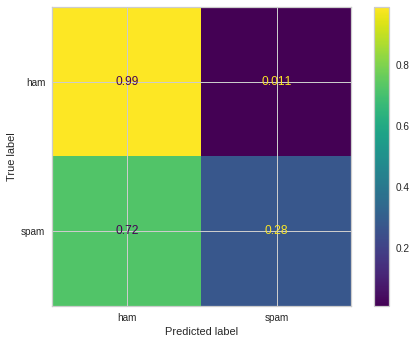

In [ ]:
tree.fit(Xsmote,Ysmote) # on entraine l'arbre sur la base SMOTE

y_pred_tree = tree.predict(X_test_sc) # Et on prédit sur la base d'origine 
print("Confusion matrix (proportions) : ")
cm = confusion_matrix(y_test,y_pred_tree,normalize='true')
#print(np.round(cm,2))
print(' ')

ConfusionMatrixDisplay(cm, display_labels=["ham","spam"]).plot()

On voit que la prédiction de la classe spam reste mauvaise. 

A vérifier : pas de bugs ? Choix des ensembles de test ? 

Confusion matrix (proportions) : 
 


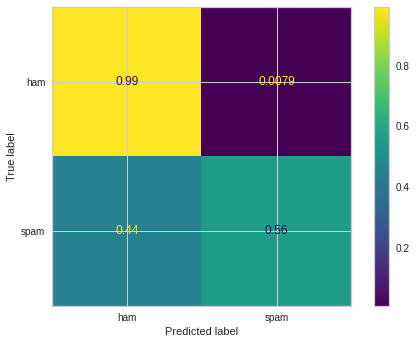

In [ ]:
y_pred_tree = tree.predict(X_deseq_sc) # Et on prédit sur la base d'origine 
print("Confusion matrix (proportions) : ")
cm = confusion_matrix(Y_deseq,y_pred_tree,normalize='true')
#print(np.round(cm,2))
print(' ')

ConfusionMatrixDisplay(cm, display_labels=["ham","spam"]).plot()

C'est déjà mieux. Mais les individus "testés" sont aussi dans la base SMOTE : les résultats sont sans doute un peu optimistes. 


Ceci illustre néamoins comme il est difficile de travailler avec des données comtenant des classes rares. 


Méthode NearMiss

In [ ]:
us = NearMiss(version=1, n_neighbors=3)
Xnear_miss, Ynear_miss = us.fit_resample(X_deseq, Y_deseq)

param_grid = {'C':[1e-02,1e-01,1,5,10]}
reglog = linear_model.LogisticRegression(penalty='l1',
                                      solver='saga',
                                      max_iter=1e4)
search = GridSearchCV(reglog, 
                      param_grid, 
                      scoring="accuracy",
                      cv=cv,
                      n_jobs=-1)
search.fit(Xnear_miss,Ynear_miss)
print('Meilleur modèle')
print(search.best_estimator_)